### Assignment 5.1: thermal wind balance


In this assignment you will analyze CTD measurements near Japan and compute the vertical shear assuming thermal wind balance. 

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gsw
import cmocean

First we will have to read the _csv_ files. Take a look at the comments and header of the first CTD dataset by running the following cell.

In [2]:
header = pd.read_csv('Japan/CTD_Japan_station_1.csv', nrows=5,  header=None)
header

,0,1,2
0,longitude,154.0,"{'axis': 'X', 'long_name': '', 'standard_name'..."
1,latitude,38.099998474121094,"{'axis': 'Y', 'long_name': '', 'standard_name'..."
2,start time,2022-10-18T00:00:00.000000000,NaN
3,end time,2022-10-18T01:06:20.000000000,NaN
4,pressure [hPa],temperature [degC],salinity [g kg-1]


To load the data in _xarray's_ useful format, we first create a new dataset with empty data. The dimensions _trajectory_ and _obs_ represent the length of each measurement and the number of measurements, respectively.

In [3]:
ctd = xr.Dataset(
    data_vars={
        'P':(('trajectory','obs'),np.zeros((399,5)),{'long_name':'pressure','units':'hPa'}),
        'T':(('trajectory','obs'),np.zeros((399,5)),{'long_name':'temperature','units':'degC'}),
        'S':(('trajectory','obs'),np.zeros((399,5)),{'long_name':'salinity','units':'g kg-1'}),
    },
    coords={
        'trajectory':('trajectory',range(399)),
        'obs':('obs',range(1,6)),
        'lat':('obs',np.zeros((5)),{'long_name':'latitude','units':'degrees_north'}),
        'lon':('obs',np.zeros((5)),{'long_name':'longitude','units':'degrees_east'}),
        'start_time':('obs',np.zeros((5), dtype='<M8[ns]'),{'long_name':'start_time'}),
        'end_time':('obs',np.zeros((5), dtype='<M8[ns]'),{'long_name':'end_time'}),
    }
)
ctd

<xarray.Dataset>
Dimensions:     (trajectory: 399, obs: 5)
Coordinates:
  * trajectory  (trajectory) int64 0 1 2 3 4 5 6 ... 392 393 394 395 396 397 398
  * obs         (obs) int64 1 2 3 4 5
    lat         (obs) float64 0.0 0.0 0.0 0.0 0.0
    lon         (obs) float64 0.0 0.0 0.0 0.0 0.0
    start_time  (obs) datetime64[ns] 1970-01-01 1970-01-01 ... 1970-01-01
    end_time    (obs) datetime64[ns] 1970-01-01 1970-01-01 ... 1970-01-01
Data variables:
    P           (trajectory, obs) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    T           (trajectory, obs) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    S           (trajectory, obs) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

__a)__ Fill the dataset with values from the csv files.

In [4]:
# Answer
for ob in range(5): # loop through files
    header = pd.read_csv(f'Japan/CTD_Japan_station_{ob+1}.csv', nrows=7,  header=None)
    ctd.lon[ob] = header.iloc[0,1]
    ctd.lat[ob] = header.iloc[1,1]
    ctd.start_time[ob] = header.iloc[2,1]
    ctd.end_time[ob] = header.iloc[3,1]
    data = pd.read_csv(f'Japan/CTD_Japan_station_{ob+1}.csv', skiprows=4)
    ctd.P[:,ob] = data['pressure [hPa]']
    ctd.T[:,ob] = data['temperature [degC]']
    ctd.S[:,ob] = data['salinity [g kg-1]']

__b)__ Integrate the hydrostatic balance equation to compute the depth z (negative everywhere) for all measurements. Use the TEOS10 approximation for density and add depth and density as variables to the dataset. Plot z for one of the CTD casts.

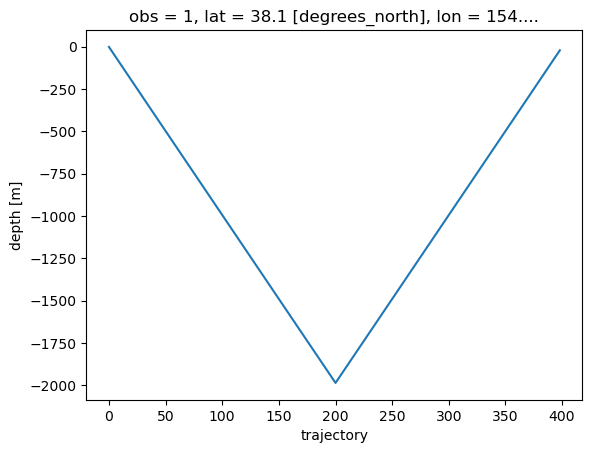

In [5]:
# Answer
g = 9.81
CT = gsw.CT_from_t(ctd.S, ctd.T, ctd.P)
Rho = gsw.density.rho(ctd.S, CT, ctd.P)
Pa = 100000 * ctd.P # bar to Pa
Pa0 = Pa.isel(trajectory=0)
Rho0 = Rho.isel(trajectory=0)
ctd['Rho'] = Rho.assign_attrs({
    'long_name':'density','standard_name':'density','units':'kg m-3'})

# calculate z (xarray style)
Rhoc = Rho.rolling(trajectory=2).mean().dropna('trajectory') # rho grid center
dz = (-1/(g*Rhoc)) * Pa.diff('trajectory')
z = xr.concat((
    xr.zeros_like(Pa0),
    dz.cumulative('trajectory').sum()
), 'trajectory') - Pa0/(Rho0*g)
ctd['z'] = xr.DataArray(z.data, z.coords, z.dims, attrs={
    'long_name':'depth','units':'m'}).transpose(*ctd.dims)

# # alternatively (numpy style, perhaps more intuitive)
# ctd['z'] = xr.zeros_like(ctd.Rho).assign_attrs({
#     'long_name':'depth','standard_name':'depth','units':'m'})
# for ob in range(5): # loop through obs
#     rho = ctd.Rho[:,ob]
#     rhoc = np.mean((rho[1:], rho[:-1]),axis=0)
#     dz = -1/(g*rhoc)*np.diff(Pa[:,ob])
#     ctd.z[0,ob] = -Pa[0,ob]/(rho[0]*g)
#     for tj in range(len(ctd.z)-1): # loop through trajectory
#         ctd.z[tj+1,ob] = ctd.z[tj,ob] + dz[tj]

# plot depth
ctd.z.isel(obs=0).plot()

As you can see, the CTD sinks and rises with a constant velocity.  

__c)__ Select the data during ascent **and** interpolate to depth levels every five metres. For the latter you can use `xr.apply_ufunc`, offering a way to apply functions on a dataset that may modify one or more specific dimensions, like e.g. `np.interp`. You only have to fill in your code in the `interp_1d` function, that is being applied along the `trajectory` dimension. This function interpolates a one-dimensional array `fp`, from its (core) dimension `trajectory` to the new dimension `zlev`. If you want to learn more about `xr.apply_ufunc`, check out this [example](https://docs.xarray.dev/en/stable/examples/apply_ufunc_vectorize_1d.html), which is very related to this exercise.

In [6]:
# Answer
print("index (trajectory) of minimum depth:",ctd.z.argmin('trajectory').data,'(obs: 5)')
trup = dict(trajectory=slice(200,None))
ctd_up = ctd.isel(trup) # select ascending portion

index (trajectory) of minimum depth: [200 200 200 200 200] (obs: 5)


In [7]:
# Answer
def interp_1d(fp, xp, x):
    """interpolate fp(xp) to x

    args:
    fp : array(k)
        variable to interpolate
    xp : array(k)
        coordinates of fp
    x : array(k)
        new coordinates of interpolated variable

    returns:
    array(k)
        values of fp interpolated to x
    """
    return np.interp(x, xp, fp)

In [8]:
# you do not have to change this
zlev = np.arange(-5,-2000,-10) # new depth levels
ctd_interp = xr.apply_ufunc(
    interp_1d, # function to apply along core dimension
    ctd_up,    # arg1
    ctd_up.z,  # arg2
    zlev,      # arg3
    input_core_dims=[['trajectory'],['trajectory'],['zlev']], # core dimension per arg
    output_core_dims=[['zlev']],      # core dimension output
    exclude_dims=set(['trajectory']), # input dimension that may disappear in output
    vectorize=True,   # vectorizes args so interp_1d receives one-dimensional data
    keep_attrs=True,  # keep array attributes
    on_missing_core_dim='copy', # how to handle possibly missing core dims on input
)
ctd_interp = ctd_interp.drop_vars('z').assign_coords(
    {'z':('zlev',zlev, ctd_interp.z.attrs)}) # set z as 1D coord
ctd_interp

<xarray.Dataset>
Dimensions:     (obs: 5, zlev: 200)
Coordinates:
  * obs         (obs) int64 1 2 3 4 5
    lat         (obs) float64 38.1 38.1 38.1 38.1 38.1
    lon         (obs) float64 154.0 154.0 154.0 154.0 154.0
    start_time  (obs) datetime64[ns] 2022-10-18 ... 2022-10-18T04:46:00
    end_time    (obs) datetime64[ns] 2022-10-18T01:06:20 ... 2022-10-18T05:52:20
    z           (zlev) int64 -5 -15 -25 -35 -45 ... -1965 -1975 -1985 -1995
Dimensions without coordinates: zlev
Data variables:
    P           (obs, zlev) float64 2.2 2.2 2.505 3.508 ... 199.0 200.1 200.2
    T           (obs, zlev) float64 25.02 25.02 24.9 24.17 ... 1.821 1.814 1.813
    S           (obs, zlev) float64 33.82 33.82 33.84 33.97 ... 34.6 34.6 34.6
    Rho         (obs, zlev) float64 1.022e+03 1.022e+03 ... 1.028e+03 1.028e+03

__d)__ Plot vertical cross sections of temperature, salinity and density with longitude and depth on the x- and y-axis, respectively.

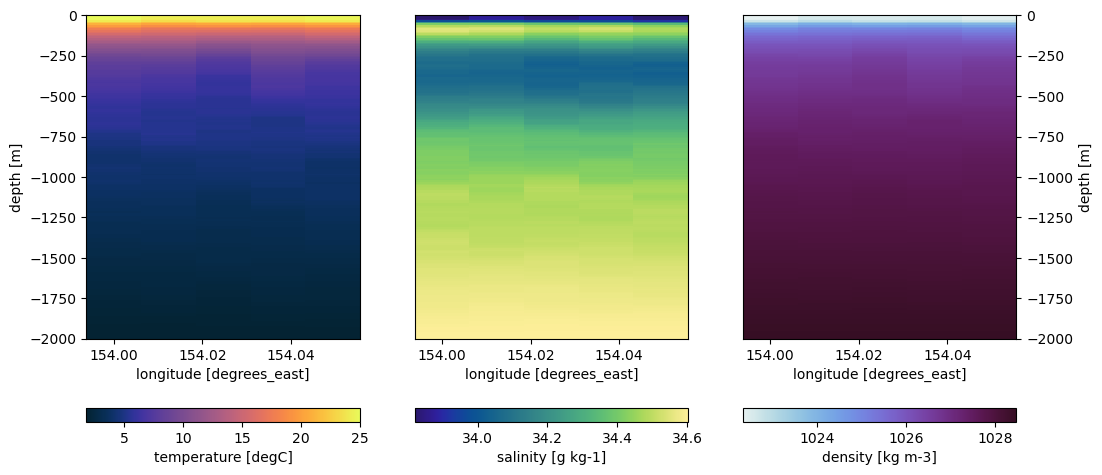

In [9]:
# Answer
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132, sharey=ax1)
ax2.yaxis.set_visible(False)
ax3 = fig.add_subplot(133, sharey=ax1)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position('right')
ctd_interp.T.plot(ax=ax1,x='lon',y='z',cmap=cmocean.cm.thermal,
                  cbar_kwargs={'orientation':'horizontal'})
ctd_interp.S.plot(ax=ax2,x='lon',y='z',cmap=cmocean.cm.haline,
                  cbar_kwargs={'orientation':'horizontal'})
ctd_interp.Rho.plot(ax=ax3,x='lon',y='z',cmap=cmocean.cm.dense,
                    cbar_kwargs={'orientation':'horizontal'})


__e)__ Calculate and plot the vertical shear of the meridional velocity, assuming the flow is in thermal wind balance.

In [10]:
# Answer
Re = 6371000          # radius earth [m]
Om = 2*np.pi/(86400)  # angular frequency earth [s-1]

latr = np.deg2rad(ctd_interp.lat) # latitude (rad)
lonr = np.deg2rad(ctd_interp.lon) # longitude (rad)
dlonr = lonr.diff('obs')   # longitude difference between casts (rad)
dx = Re*np.cos(latr)*dlonr # distance between cast locations (m)
f = 2*Om*np.sin(latr)      # coriolis parameter

rho = ctd_interp.Rho         # density (kg m-3)
drho = rho.diff('obs')       # density difference between casts (kg m-3)
dvdz = -g/(f*rho) * drho/dx  # vertical shear of meridional flow (m s-1)

Text(0.5, 1.0, 'vertical shear of meridional velocity')

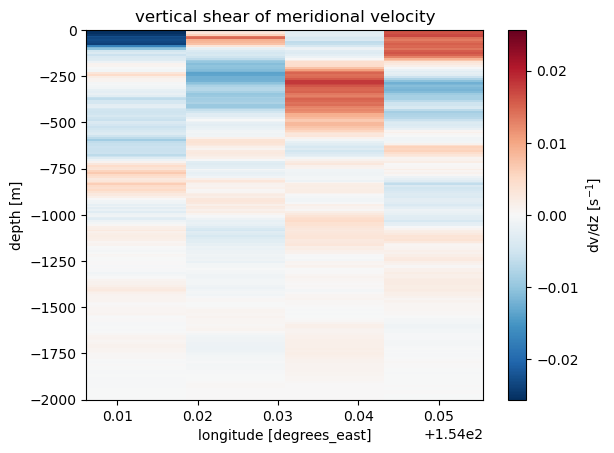

In [11]:
dvdz.plot.pcolormesh(x='lon',y='z',cbar_kwargs={'label':r'dv/dz [s$^{-1}$]'})
plt.title('vertical shear of meridional velocity')